## Import Library

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

In [111]:
# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if
torch.cuda.is_available() else "cpu")

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting PATH

In [113]:
IMAGE_PATH ='/content/drive/My Drive/PENS/Neuro Computing/aerial_test/dataset/semantic_drone_dataset/original_images/'
MASK_PATH ='/content/drive/My Drive/PENS/Neuro Computing//aerial_test/dataset/semantic_drone_dataset/label_images_semantic/'

## Membuat Data Frame

In [114]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  10


## Data Split

In [115]:
X_trainval, X_test = train_test_split(df['id'].values,
                                      test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval,
                                  test_size=0.15, random_state=19)

print('Train Size : ', len(X_train))
print('Val Size : ', len(X_val))
print('Test Size : ', len(X_test))

Train Size :  7
Val Size :  2
Test Size :  1


## Show Images

Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


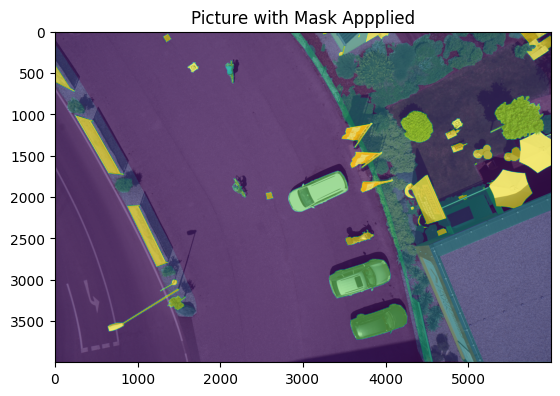

In [116]:
img = Image.open(IMAGE_PATH + df['id'][1] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][1] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

## Make Function

In [117]:
class DroneDataset(Dataset):
  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
        aug = self.transform(image=img, mask=mask)
        img = Image.fromarray(aug['image'])
        mask = aug['mask']

    if self.transform is None:
        img = Image.fromarray(img)

    t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
    img = t(img)
    mask = torch.from_numpy(mask).long()

    if self.patches:
        img, mask = self.tiles(img, mask)

    return img, mask

    def tiles(self, img, mask):
      img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
      img_patches = img_patches.contiguous().view(3,-1, 512, 768)

      img_patches = img_patches.permute(1,0,2,3)

      mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
      mask_patches = mask_patches.contiguous().view(-1, 512, 768)

      return img_patches, mask_patches

## Interpolation

In [118]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0,0.5),(0,0.5)),
    A.GaussNoise()])

t_val = A.Compose([
    A.Resize(704, 1056,interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)])

## Data Loader

In [119]:
# datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH,
X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val,
mean, std, t_val, patch=False)

# dataloader
batch_size= 3

train_loader = DataLoader(train_set,
batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set,
batch_size=batch_size, shuffle=True)

## Model

In [120]:
model = smp.Unet('mobilenet_v2',encoder_weights='imagenet',
                 classes=23,activation=None, encoder_depth=5,
                 decoder_channels=[256, 128, 64, 32, 16])
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

## Model Pixel Accuracy

In [121]:
def pixel_accuracy(output, mask):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output,dim=1), dim=1)

    correct = torch.eq(output, mask).int()
    accuracy = float(correct.sum()) / float(correct.numel())
  return accuracy

## Make mean Intersection over Union (mIoU)

In [122]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
  with torch.no_grad():
    pred_mask = F.softmax(pred_mask, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.contiguous().view(-1)
    mask = mask.contiguous().view(-1)

    iou_per_class = []
    for clas in range(0, n_classes): #loop per pixel class
      true_class = pred_mask == clas
      true_label = mask == clas

      if true_label.long().sum().item() == 0: #no exist label in this loop
        iou_per_class.append(np.nan)

      else:
        intersect = torch.logical_and(true_class,true_label).sum().float().item()
        union = torch.logical_or(true_class, true_label).sum().float().item()
        iou = (intersect + smooth) / (union +smooth)
        iou_per_class.append(iou)
    return np.nanmean(iou_per_class)

## Function LR

In [123]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

## Model Function Fit

In [124]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss,
                 (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len
                     (val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()-fit_time)/60))
    return history

## Model Fit

In [125]:
max_lr = 1e-2
epoch = 25
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=max_lr,momentum=0.9, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion,optimizer, sched)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.173 
Epoch:1/25.. Train Loss: 3.278.. Val Loss: 3.173.. Train mIoU:0.014.. Val mIoU: 0.012.. Train Acc:0.045.. Val Acc:0.045.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 3.173 >> 3.099 
Epoch:2/25.. Train Loss: 3.181.. Val Loss: 3.099.. Train mIoU:0.017.. Val mIoU: 0.018.. Train Acc:0.070.. Val Acc:0.095.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 3.099 >> 2.915 
Epoch:3/25.. Train Loss: 3.002.. Val Loss: 2.915.. Train mIoU:0.029.. Val mIoU: 0.027.. Train Acc:0.168.. Val Acc:0.265.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.915 >> 2.667 
saving model...
Epoch:4/25.. Train Loss: 2.581.. Val Loss: 2.667.. Train mIoU:0.040.. Val mIoU: 0.026.. Train Acc:0.410.. Val Acc:0.338.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.667 >> 2.408 
Epoch:5/25.. Train Loss: 2.157.. Val Loss: 2.408.. Train mIoU:0.038.. Val mIoU: 0.022.. Train Acc:0.493.. Val Acc:0.370.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.408 >> 2.317 
Epoch:6/25.. Train Loss: 1.911.. Val Loss: 2.317.. Train mIoU:0.045.. Val mIoU: 0.022.. Train Acc:0.544.. Val Acc:0.370.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.317 >> 2.225 
Epoch:7/25.. Train Loss: 1.885.. Val Loss: 2.225.. Train mIoU:0.038.. Val mIoU: 0.030.. Train Acc:0.513.. Val Acc:0.373.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:8/25.. Train Loss: 1.883.. Val Loss: 2.300.. Train mIoU:0.037.. Val mIoU: 0.044.. Train Acc:0.468.. Val Acc:0.345.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.300 >> 2.182 
Epoch:9/25.. Train Loss: 1.756.. Val Loss: 2.182.. Train mIoU:0.057.. Val mIoU: 0.049.. Train Acc:0.479.. Val Acc:0.387.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.182 >> 2.067 
saving model...
Epoch:10/25.. Train Loss: 1.622.. Val Loss: 2.067.. Train mIoU:0.072.. Val mIoU: 0.054.. Train Acc:0.538.. Val Acc:0.427.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.067 >> 1.868 
Epoch:11/25.. Train Loss: 1.521.. Val Loss: 1.868.. Train mIoU:0.092.. Val mIoU: 0.069.. Train Acc:0.583.. Val Acc:0.512.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.868 >> 1.680 
Epoch:12/25.. Train Loss: 1.496.. Val Loss: 1.680.. Train mIoU:0.099.. Val mIoU: 0.083.. Train Acc:0.576.. Val Acc:0.593.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.680 >> 1.602 
Epoch:13/25.. Train Loss: 1.572.. Val Loss: 1.602.. Train mIoU:0.104.. Val mIoU: 0.086.. Train Acc:0.550.. Val Acc:0.625.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:14/25.. Train Loss: 1.288.. Val Loss: 1.657.. Train mIoU:0.121.. Val mIoU: 0.092.. Train Acc:0.639.. Val Acc:0.615.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.657 >> 1.574 
Epoch:15/25.. Train Loss: 1.216.. Val Loss: 1.574.. Train mIoU:0.135.. Val mIoU: 0.104.. Train Acc:0.650.. Val Acc:0.646.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.574 >> 1.570 
saving model...
Epoch:16/25.. Train Loss: 1.254.. Val Loss: 1.570.. Train mIoU:0.124.. Val mIoU: 0.101.. Train Acc:0.641.. Val Acc:0.626.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.570 >> 1.494 
Epoch:17/25.. Train Loss: 1.225.. Val Loss: 1.494.. Train mIoU:0.134.. Val mIoU: 0.096.. Train Acc:0.647.. Val Acc:0.647.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.494 >> 1.475 
Epoch:18/25.. Train Loss: 1.314.. Val Loss: 1.475.. Train mIoU:0.127.. Val mIoU: 0.104.. Train Acc:0.600.. Val Acc:0.656.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.475 >> 1.429 
Epoch:19/25.. Train Loss: 1.105.. Val Loss: 1.429.. Train mIoU:0.156.. Val mIoU: 0.104.. Train Acc:0.682.. Val Acc:0.671.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:20/25.. Train Loss: 1.077.. Val Loss: 1.461.. Train mIoU:0.157.. Val mIoU: 0.106.. Train Acc:0.698.. Val Acc:0.650.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.461 >> 1.371 
Epoch:21/25.. Train Loss: 1.095.. Val Loss: 1.371.. Train mIoU:0.155.. Val mIoU: 0.103.. Train Acc:0.689.. Val Acc:0.680.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:22/25.. Train Loss: 1.200.. Val Loss: 1.385.. Train mIoU:0.135.. Val mIoU: 0.108.. Train Acc:0.633.. Val Acc:0.667.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:23/25.. Train Loss: 1.160.. Val Loss: 1.392.. Train mIoU:0.160.. Val mIoU: 0.109.. Train Acc:0.657.. Val Acc:0.684.. Time: 0.10m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:24/25.. Train Loss: 1.161.. Val Loss: 1.402.. Train mIoU:0.152.. Val mIoU: 0.102.. Train Acc:0.650.. Val Acc:0.663.. Time: 0.09m


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.402 >> 1.394 
saving model...
Epoch:25/25.. Train Loss: 1.181.. Val Loss: 1.394.. Train mIoU:0.146.. Val mIoU: 0.099.. Train Acc:0.645.. Val Acc:0.681.. Time: 0.09m
Total time: 2.29 m


## Save Model

In [126]:
torch.save(model, '/content/drive/My Drive/PENS/Neuro Computing/Unet-Mobilenet.pt')

## Function Plot

In [127]:
def plot_loss(history):
  plt.plot(history['val_loss'], label='val', marker='o')
  plt.plot( history['train_loss'], label='train', marker='o')
  plt.title('Loss per epoch'); plt.ylabel('loss');
  plt.xlabel('epoch')
  plt.legend(), plt.grid()
  plt.show()

def plot_score(history):
  plt.plot(history['train_miou'], label='train_mIoU', marker='*')
  plt.plot(history['val_miou'], label='val_mIoU', marker='*')
  plt.title('Score per epoch'); plt.ylabel('mean IoU')
  plt.xlabel('epoch')
  plt.legend(), plt.grid()
  plt.show()

def plot_acc(history):
  plt.plot(history['train_acc'], label='train_accuracy', marker='*')
  plt.plot(history['val_acc'], label='val_accuracy', marker='*')
  plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(), plt.grid()
  plt.show()

## Show Plot

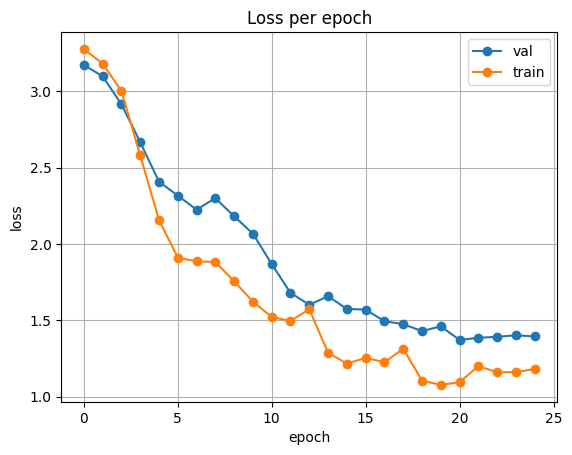

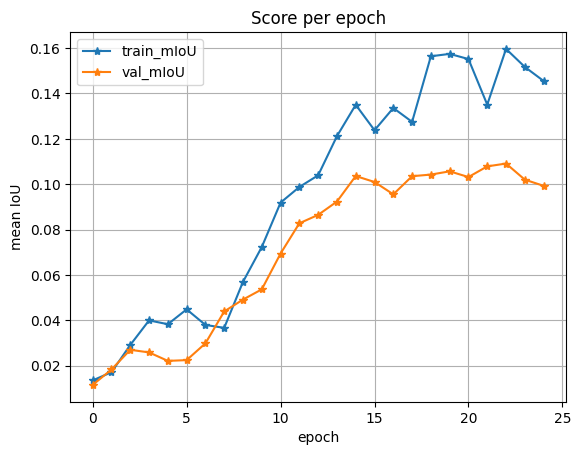

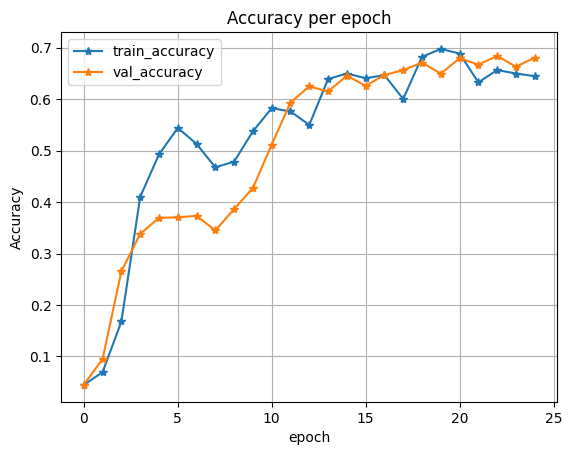

In [128]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Funtion Data Test

In [129]:
class DroneTestDataset(Dataset):

  def __init__(self, img_path, mask_path, X, transform=None):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
      aug = self.transform(image=img, mask=mask)
      img = Image.fromarray(aug['image'])
      mask = aug['mask']
    if self.transform is None:
      img = Image.fromarray(img)

    mask = torch.from_numpy(mask).long()
    return img, mask

## Call Test Set

In [130]:
t_test = A.Resize(768, 1152,
interpolation=cv2.INTER_NEAREST)

test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH,
X_test, transform=t_test)

## Function Predict mIoU

In [131]:
def predict_image_mask_miou(model, image, mask,
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]):
  model.eval()
  t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
  image = t(image)
  model.to(device); image=image.to(device)
  mask = mask.to(device)
  with torch.no_grad():

    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    output = model(image)
    score = mIoU(output, mask)
    masked = torch.argmax(output, dim=1)
    masked = masked.cpu().squeeze(0)
  return masked, score

## Function Predict Mask Pixel

In [132]:
def predict_image_mask_pixel(model, image, mask,
                             mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]):
  model.eval()
  t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
  image = t(image)
  model.to(device); image=image.to(device)
  mask = mask.to(device)
  with torch.no_grad():

    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

  output = model(image)
  acc = pixel_accuracy(output, mask)
  masked = torch.argmax(output, dim=1)
  masked = masked.cpu().squeeze(0)
  return masked, acc

## Prediction

In [133]:
image, mask = test_set[0] #change number to 0 from 3
pred_mask, score = predict_image_mask_miou(model, image, mask)

## mIoU Score

In [134]:
def miou_score(model, test_set):
  score_iou = []
  for i in tqdm(range(len(test_set))):
    img, mask = test_set[i]
    pred_mask, score = predict_image_mask_miou(model, img, mask)
    score_iou.append(score)
  return score_iou

mob_miou = miou_score(model, test_set)

  0%|          | 0/1 [00:00<?, ?it/s]

## Pixel Score

In [135]:
def pixel_acc(model, test_set):
  accuracy = []
  for i in tqdm(range(len(test_set))):
    img, mask = test_set[i]
    pred_mask, acc = predict_image_mask_pixel(model, img, mask)
    accuracy.append(acc)
  return accuracy

mob_acc = pixel_acc(model, test_set)

  0%|          | 0/1 [00:00<?, ?it/s]

## Show Predict

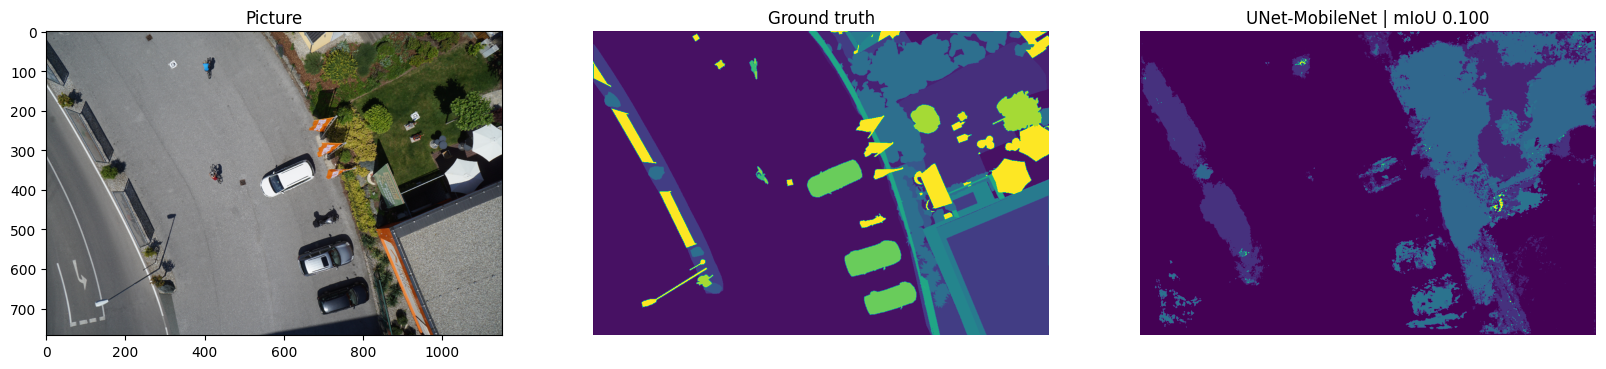

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()